In [1]:
from skimage.measure import compare_ssim as ssim
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
def compare_images(imageA, imageB, title):
	# compute the mean squared error and structural similarity
	# index for the images
# 	m = mse(imageA, imageB)
	s = ssim(imageA, imageB)
 
	# setup the figure
	fig = plt.figure(title)
	plt.suptitle("SSIM: %.2f" % (s))
 
	# show first image
	ax = fig.add_subplot(1, 2, 1)
	plt.imshow(imageA, cmap = plt.cm.gray)
	plt.axis("off")
 
	# show the second image
	ax = fig.add_subplot(1, 2, 2)
	plt.imshow(imageB, cmap = plt.cm.gray)
	plt.axis("off")
 
	# show the images
	plt.show()

In [6]:
original = cv2.imread("/Users/elinabian 1/Desktop/CU-life/intern/洋葱数学/videology_4.0/test1.bmp")
contrast = cv2.imread("/Users/elinabian 1/Desktop/CU-life/intern/洋葱数学/videology_4.0/test2.bmp")
original = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
contrast = cv2.cvtColor(contrast, cv2.COLOR_BGR2GRAY)

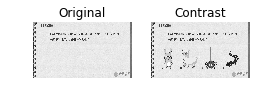

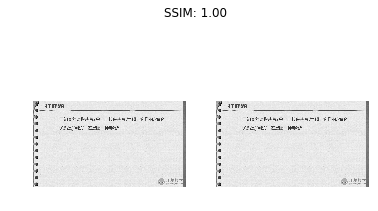

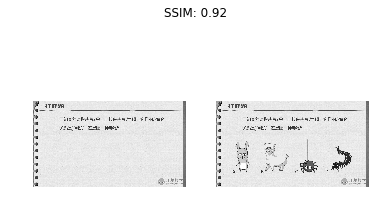

In [7]:
# initialize the figure
fig = plt.figure("Images")
images = ("Original", original), ("Contrast", contrast)
 
# loop over the images
for (i, (name, image)) in enumerate(images):
	# show the image
	ax = fig.add_subplot(1, 3, i + 1)
	ax.set_title(name)
	plt.imshow(image, cmap = plt.cm.gray)
	plt.axis("off")

    
plt.show()
 
# compare the images
compare_images(original, original, "Original vs. Original")
compare_images(original, contrast, "Original vs. Contrast")
# compare_images(original, shopped, "Original vs. Photoshopped")

In [46]:
# cut m3u8 video into images


from subprocess import call        # write bash command in python

base_dir = '/Users/elinabian 1/Desktop/CU-life/intern/洋葱数学/videology_4.0'

def process_video(m3u8_path, num):
    os.chdir(base_dir)
    # call(['rm', '-rf', 'bmps'])
    # call(['rm', 'output.mp4'])
    
    # download mp4
    txt = 'ffmpeg -i https://hls.media.yangcong345.com/high/high_57d6b670ba53a54020ced8cf.m3u8 -c copy -bsf:a aac_adtstoasc output.mp4'
    # 替换txt中的网址部分
    cmd = txt.split(' ')
    cmd[2] = m3u8_path
    cmd[-1] = 'output' + str(num) + '.mp4'
    call(cmd)
    
    # extract images
    call(['mkdir', 'bmps%s'%str(num)])
    cmd = ('ffmpeg -i output%s.mp4'%str(num) + ' -r 2 -ss 00:08:00 -f bmps%s'%str(num) + '/%04d.bmp').split()
    call(cmd)

In [47]:
process_video('https://hls.media.yangcong345.com/high/high_586ef48c065b7e9d71429685.m3u8',1)
process_video('https://hls.media.yangcong345.com/high/high_586f01cf065b7e9d71429693.m3u8',2)
process_video('https://hls.media.yangcong345.com/high/high_586edda2065b7e9d7142966b.m3u8',3)
process_video('https://hls.media.yangcong345.com/high/high_586e42ae065b7e9d714295e5.m3u8',4)

In [57]:
THRES = .95


# judge the similarity of two images using method above
def judge_images(ia, ib, thres=THRES):
    
    a = cv2.imread(ia)
    b = cv2.imread(ib)
    
    a = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
    b = cv2.cvtColor(b, cv2.COLOR_BGR2GRAY)
    
    s = ssim(a, b)
    return s >= thres


def get_turnover(image_set_dir, thres=THRES, interval=1):
    x = os.listdir(image_set_dir)
    x = sorted(['/' +t for t in x if t[-3:] == 'bmp'])
    
    result = list()

    for i in range(0, len(x) - interval):
        this_image = image_set_dir + x[i]
        next_image = image_set_dir + x[i+interval]

        t = judge_images(this_image, next_image, thres)

        if not t:
            result.append(x[i])
    
    return result

In [81]:
# judge the similarity of two images using PHash algorithm


from itertools import chain

def pHash(imgfile):
    """get image pHash value"""
    #加载并调整图片为32x32灰度图片
    img=cv2.imread(imgfile, 0) 
    img=cv2.resize(img,(64,64),interpolation=cv2.INTER_CUBIC)

    #创建二维列表
    h, w = img.shape[:2]
    vis0 = np.zeros((h,w), np.float32)
    #填充数据
    vis0[:h,:w] = img      

    #二维Dct变换
    vis1 = cv2.dct(cv2.dct(vis0))
    vis1.resize(32,32)

    #把二维list变成一维list
    img_list = list(chain.from_iterable(vis1.tolist()))

    #计算均值
    avg = sum(img_list)*1./len(img_list)
    avg_list = ['0' if i<avg else '1' for i in img_list]

    #得到哈希值
    return ''.join(['%x' % int(''.join(avg_list[x:x+4]),2) for x in range(0,32*32,4)])

def hammingDist(s1, s2):
    assert len(s1) == len(s2)
    return sum([ch1 != ch2 for ch1, ch2 in zip(s1, s2)])


THRES_2 = 0.87

def turnover_2(res, txt, thres=THRES_2, interval=1):
    x = res
    x = sorted([t for t in x if t[-3:] == 'bmp'])
    
    result = list()
    score = []

    for i in range(0, len(x) - interval):
        this_image = txt + x[i]
        next_image = txt + x[i+interval] 
        HASH1=pHash(this_image)
        HASH2=pHash(next_image)

        out_score = 1 - hammingDist(HASH1,HASH2)*1. / (32*32/4)
#           print(out_score)
        score.append(out_score)
        if out_score <= thres:
            result.append(x[i])
    
    return result

In [49]:
print(base_dir)

/Users/elinabian 1/Desktop/CU-life/intern/洋葱数学/videology_4.0


In [105]:
image_set_dir_1 = base_dir + '/bmps1'
r1 = get_turnover(image_set_dir_1)
print(r1)

res1 = []
for i in range(1, len(r1)-2):
    p1 = int(r1[i-1][1:5])
    p2 = int(r1[i][1:5])
    p3 = int(r1[i+1][1:5])
    if p2-p1 >= 10 and p3-p1 != 2:
        res1.append(r1[i])
res1

['/0007.bmp', '/0008.bmp', '/0009.bmp', '/0010.bmp', '/0011.bmp', '/0012.bmp', '/0013.bmp', '/0015.bmp', '/0018.bmp', '/0026.bmp', '/0027.bmp', '/0028.bmp', '/0029.bmp', '/0036.bmp', '/0037.bmp', '/0038.bmp', '/0039.bmp', '/0040.bmp', '/0041.bmp', '/0062.bmp', '/0063.bmp', '/0065.bmp', '/0070.bmp', '/0071.bmp', '/0078.bmp', '/0088.bmp', '/0117.bmp', '/0123.bmp', '/0124.bmp', '/0165.bmp', '/0166.bmp', '/0191.bmp', '/0230.bmp', '/0231.bmp', '/0265.bmp', '/0266.bmp', '/0286.bmp', '/0361.bmp', '/0369.bmp', '/0370.bmp', '/0382.bmp', '/0383.bmp', '/0412.bmp', '/0428.bmp', '/0459.bmp', '/0465.bmp', '/0526.bmp', '/0527.bmp', '/0528.bmp', '/0529.bmp', '/0535.bmp', '/0547.bmp', '/0548.bmp', '/0565.bmp', '/0566.bmp', '/0582.bmp', '/0584.bmp', '/0594.bmp']


['/0062.bmp',
 '/0088.bmp',
 '/0117.bmp',
 '/0165.bmp',
 '/0191.bmp',
 '/0230.bmp',
 '/0265.bmp',
 '/0286.bmp',
 '/0361.bmp',
 '/0382.bmp',
 '/0412.bmp',
 '/0428.bmp',
 '/0459.bmp',
 '/0526.bmp',
 '/0547.bmp',
 '/0565.bmp',
 '/0582.bmp']

In [117]:
print(res1)
res11 = turnover_2(res = res1, txt = image_set_dir_1, thres = 0.87)
res11

['/0062.bmp', '/0088.bmp', '/0117.bmp', '/0165.bmp', '/0191.bmp', '/0230.bmp', '/0265.bmp', '/0286.bmp', '/0361.bmp', '/0382.bmp', '/0412.bmp', '/0428.bmp', '/0459.bmp', '/0526.bmp', '/0547.bmp', '/0565.bmp', '/0582.bmp']


['/0062.bmp',
 '/0165.bmp',
 '/0230.bmp',
 '/0361.bmp',
 '/0382.bmp',
 '/0526.bmp',
 '/0547.bmp',
 '/0565.bmp']

In [110]:
image_set_dir_2 = base_dir + '/bmps2'
r2 = get_turnover(image_set_dir_2)
print(r2)

res2 = []
for i in range(1, len(r2)-2):
    p1 = int(r2[i-1][1:5])
    p2 = int(r2[i][1:5])
    p3 = int(r2[i+1][1:5])
    if p2-p1 >= 10 and p3-p1 != 2:
        res2.append(r2[i])
res2


['/0007.bmp', '/0008.bmp', '/0009.bmp', '/0010.bmp', '/0011.bmp', '/0012.bmp', '/0013.bmp', '/0015.bmp', '/0018.bmp', '/0019.bmp', '/0042.bmp', '/0043.bmp', '/0071.bmp', '/0200.bmp', '/0232.bmp', '/0239.bmp', '/0250.bmp', '/0259.bmp', '/0260.bmp', '/0287.bmp', '/0306.bmp', '/0318.bmp', '/0319.bmp', '/0320.bmp', '/0335.bmp', '/0338.bmp', '/0349.bmp', '/0378.bmp']


['/0042.bmp', '/0071.bmp']

In [125]:
print(res2)
res22 = turnover_2(res = res2, txt = image_set_dir_2, thres=0.95)
res22

['/0042.bmp', '/0071.bmp', '/0200.bmp', '/0232.bmp', '/0250.bmp', '/0287.bmp', '/0306.bmp', '/0318.bmp', '/0335.bmp']


['/0042.bmp', '/0071.bmp', '/0200.bmp', '/0287.bmp', '/0306.bmp']

In [126]:
image_set_dir_3 = base_dir + '/bmps3'
r3 = get_turnover(image_set_dir_3)
print(r3)

res3 = []
for i in range(1, len(r3)-2):
    p1 = int(r3[i-1][1:5])
    p2 = int(r3[i][1:5])
    p3 = int(r3[i+1][1:5])
    if p2-p1 >= 10 and p3-p1 != 2:
        res3.append(r3[i])
res3
res33 = turnover_2(res = res3, txt = image_set_dir_3)
res33

['/0003.bmp', '/0004.bmp', '/0005.bmp', '/0006.bmp', '/0007.bmp', '/0010.bmp', '/0025.bmp', '/0057.bmp', '/0074.bmp', '/0079.bmp', '/0082.bmp', '/0086.bmp', '/0091.bmp', '/0096.bmp', '/0113.bmp', '/0116.bmp', '/0117.bmp', '/0124.bmp', '/0136.bmp', '/0137.bmp', '/0143.bmp', '/0148.bmp', '/0156.bmp', '/0162.bmp', '/0163.bmp', '/0170.bmp', '/0180.bmp', '/0191.bmp', '/0224.bmp', '/0246.bmp', '/0270.bmp', '/0272.bmp', '/0284.bmp', '/0285.bmp', '/0294.bmp']


['/0025.bmp', '/0057.bmp', '/0074.bmp', '/0113.bmp', '/0191.bmp', '/0224.bmp']

In [127]:
image_set_dir_4 = base_dir + '/bmps4'
r4 = get_turnover(image_set_dir_4)
print(r4)

res4 = []
for i in range(1, len(r4)-2):
    p1 = int(r4[i-1][1:5])
    p2 = int(r4[i][1:5])
    p3 = int(r4[i+1][1:5])
    if p2-p1 >= 10 and p3-p1 != 2:
        res4.append(r4[i])
res4
res44 = turnover_2(res = res4, txt = image_set_dir_4)
res44

['/0003.bmp', '/0004.bmp', '/0005.bmp', '/0006.bmp', '/0008.bmp', '/0019.bmp', '/0022.bmp', '/0023.bmp', '/0029.bmp', '/0030.bmp', '/0035.bmp', '/0046.bmp', '/0051.bmp', '/0086.bmp', '/0104.bmp', '/0131.bmp', '/0132.bmp', '/0166.bmp', '/0169.bmp', '/0212.bmp', '/0213.bmp', '/0240.bmp', '/0261.bmp', '/0330.bmp', '/0335.bmp', '/0336.bmp', '/0423.bmp']


['/0131.bmp', '/0166.bmp', '/0212.bmp', '/0261.bmp']